In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import imutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

In [2]:
from google.colab import files
uploaded = files.upload()



Saving data.zip to data.zip


In [3]:
import zipfile
import io
data = zipfile.ZipFile(io.BytesIO(uploaded['data.zip']), 'r')
data.extractall()

data.printdir()

File Name                                             Modified             Size
data/                                          2020-09-12 21:44:32            0
data/without_mask/                             2020-09-12 21:44:32            0
data/without_mask/.DS_Store                    2020-09-12 21:29:28         6148
data/without_mask/0.jpg                        2020-09-12 21:29:34        21764
data/without_mask/0_0_aidai_0014.jpg           2020-09-12 21:31:06         6318
data/without_mask/0_0_aidai_0029.jpg           2020-09-12 21:30:32         7615
data/without_mask/0_0_aidai_0043.jpg           2020-09-12 21:30:26         8266
data/without_mask/0_0_aidai_0074.jpg           2020-09-12 21:30:36         5868
data/without_mask/0_0_aidai_0084.jpg           2020-09-12 21:30:30         6299
data/without_mask/0_0_aidai_0136.jpg           2020-09-12 21:30:38         7605
data/without_mask/0_0_anhu_0004.jpg            2020-09-12 21:31:44         7215
data/without_mask/0_0_anhu_0020.jpg     

In [4]:
from imutils import paths
import os
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

imagePaths = list(paths.list_images('data'))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)
	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [5]:
baseModel = tf.keras.applications.MobileNetV2(weights="imagenet", include_top=False,
	input_shape=(224, 224, 3))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = tf.keras.layers.AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = tf.keras.layers.Flatten(name="flatten")(headModel)
headModel = tf.keras.layers.Dense(128, activation="relu")(headModel)
headModel = tf.keras.layers.Dropout(0.5)(headModel)
headModel = tf.keras.layers.Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
	layer.trainable = False

INIT_LR = 1e-4
EPOCHS = 20
opt = tf.keras.optimizers.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

9412608/9406464 [==============================] - 0s 0us/step


In [6]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [7]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
print("[INFO] compiling model...")
opt = tf.keras.optimizers.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
95/95 [==============================] - 159s 2s/step - loss: 0.3399 - accuracy: 0.8527 - val_loss: 0.0991 - val_accuracy: 0.9778
Epoch 2/20
95/95 [==============================] - 151s 2s/step - loss: 0.1208 - accuracy: 0.9581 - val_loss: 0.0585 - val_accuracy: 0.9817
Epoch 3/20
95/95 [==============================] - 151s 2s/step - loss: 0.0835 - accuracy: 0.9703 - val_loss: 0.0418 - val_accuracy: 0.9909
Epoch 4/20
95/95 [==============================] - 151s 2s/step - loss: 0.0674 - accuracy: 0.9763 - val_loss: 0.0360 - val_accuracy: 0.9870
Epoch 5/20
95/95 [==============================] - 149s 2s/step - loss: 0.0641 - accuracy: 0.9786 - val_loss: 0.0318 - val_accuracy: 0.9922
Epoch 6/20
95/95 [==============================] - 150s 2s/step - loss: 0.0483 - accuracy: 0.9845 - val_loss: 0.0288 - val_accuracy: 0.9922
Epoch 7/20
95/95 [==============================] - 151s 2s/step - loss: 0.0464 - accuracy: 0.9845 - val

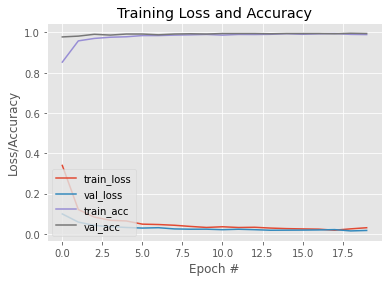

In [8]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [9]:
model.save('mask_recog_ver2.h5')